# 4 imputs (N,Z,dq,uq) and 1 outputs (Seperation energy) in single ANN

# Imports

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)
print(now)

C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-seperation-output
2019-08-21-17-02-40


In [2]:
#%matplotlib notebook

# Read the data set

In [3]:
df = pd.read_csv("better-nuclei-19-08.csv")
print(df.info())
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
Z                                  3436 non-null int64
N                                  3436 non-null int64
UQ                                 3436 non-null int64
DQ                                 3436 non-null int64
Mass Excess [MeV]                  3436 non-null float64
Mass Error                         3436 non-null float64
Mass Estimated                     3436 non-null int64
Neutron separation energy [MeV]    3318 non-null float64
Separation Error                   3318 non-null float64
Separation Estimated               3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


Index(['Z', 'N', 'UQ', 'DQ', 'Mass Excess [MeV]', 'Mass Error',
       'Mass Estimated', 'Neutron separation energy [MeV]', 'Separation Error',
       'Separation Estimated'],
      dtype='object')

In [4]:
df = df.rename(columns=
               {"Mass Excess [MeV]": "d",
                "Z":'z',
                'N':'n',
                'UQ':"uq",
                'DQ':"dq",
                "Mass Error":"mass error",
                "Mass Estimated":"mass estimated",
                "Neutron separation energy [MeV]":"d2",
                "Separation Error":"separation error",
                "Separation Estimated":"separation estimated"               
               })
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
z                       3436 non-null int64
n                       3436 non-null int64
uq                      3436 non-null int64
dq                      3436 non-null int64
d                       3436 non-null float64
mass error              3436 non-null float64
mass estimated          3436 non-null int64
d2                      3318 non-null float64
separation error        3318 non-null float64
separation estimated    3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


In [5]:
df.describe()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3318.000000,3318.000000,3318.000000
mean,57.857392,82.034051,197.748836,221.925495,-24.144121,0.123589,0.272992,7.755557,0.164216,0.295660
std,27.809406,43.293558,98.188326,113.771063,56.200706,0.197548,0.445562,3.631747,0.254378,0.456408
min,0.000000,0.000000,1.000000,1.000000,-91.652853,0.000000,0.000000,-2.488000,0.000000,0.000000
25%,36.000000,47.000000,120.750000,131.000000,-65.400443,0.003006,0.000000,5.414787,0.005140,0.000000
50%,58.000000,81.000000,197.000000,219.000000,-39.335024,0.014474,0.000000,7.249960,0.025005,0.000000
75%,80.000000,114.000000,273.000000,308.000000,1.172301,0.196000,1.000000,9.654658,0.269058,1.000000
max,118.000000,177.000000,413.000000,472.000000,201.512000,2.003000,1.000000,27.715000,2.011000,1.000000


# Remove estimated Excess and estimated Seperation

In [6]:
not_estimated_filter = (df["mass estimated"] == 0)
df = df[not_estimated_filter]

not_estimated_filter = (df["separation estimated"] == 0)
df = df[not_estimated_filter]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


In [8]:
df.isnull().values.any()

False

In [9]:
df['z'].shape

(2337,)

In [10]:
df.count()

z                       2337
n                       2337
uq                      2337
dq                      2337
d                       2337
mass error              2337
mass estimated          2337
d2                      2337
separation error        2337
separation estimated    2337
dtype: int64

In [11]:
df.head()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
0,0,1,1,2,8.071317,4.000000e-07,0,0.00000,0.00000,0.0
2,1,1,3,3,13.135722,1.000000e-07,0,2.22457,0.00000,0.0
3,1,2,4,5,14.949810,2.000000e-07,0,6.25723,0.00000,0.0
4,1,3,5,7,24.621127,1.000000e-01,0,-1.60000,0.10000,0.0
5,1,4,6,9,32.892444,8.944300e-02,0,-0.20000,0.13416,0.0


# Plot seperation energy column

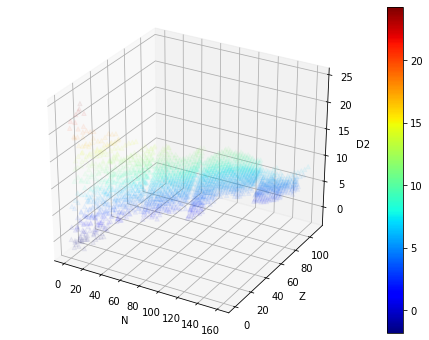

In [12]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d2']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D2')


plt.show()

In [13]:
df['d2'].to_numpy().shape

(2337,)

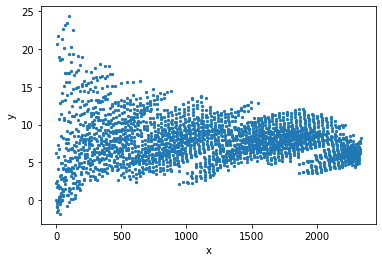

In [14]:
plt.scatter(range(df['d2'].count()), df['d2'].to_numpy(), s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Dividing Mass Excess by A = Z + N

In [15]:
zes = df['z'].to_numpy()
ns = df['n'].to_numpy()
a = zes + ns

des = df['d'].to_numpy() / a
df['d'] = des


# Plot Mass excess output column

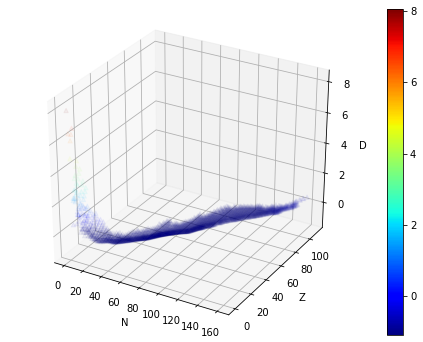

In [16]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Tripcolor

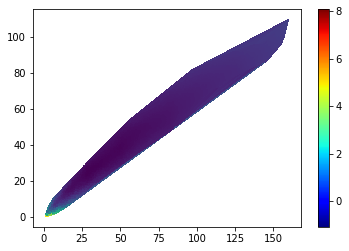

In [17]:
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

#yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)


fig, (ax)=plt.subplots(ncols=1)
ax.tripcolor(df["n"], df["z"], df["d"])
cb = fig.colorbar(colmap)

plt.show()

# Set X inputs

In [18]:
x = df[['z','n','dq','uq']]
print(x.info())
x = x.to_numpy()
print(x.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 4 columns):
z     2337 non-null int64
n     2337 non-null int64
dq    2337 non-null int64
uq    2337 non-null int64
dtypes: int64(4)
memory usage: 91.3 KB
None
(2337, 4)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


# Set Y inputs _(HERE CHANGE NUMBER OF INPUTS AND RESHAPE)

In [20]:
y = df[['d2']].to_numpy() #HERE
y.shape

(2337, 1)

In [21]:
y = y.reshape(-1,1) #HERE
y.shape

(2337, 1)

In [22]:
y[0:5]

array([[ 0.     ],
       [ 2.22457],
       [ 6.25723],
       [-1.6    ],
       [-0.2    ]])

# Prepare X_train_o, Y_train_o etc

In [23]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)
n_inputs = X_train_o.shape[1]
n_outputs = y_train_o.shape[1]
print(n_inputs)
print(n_outputs)
print(X_train_o.shape, X_test_o.shape,X_val_o.shape)

4
1
(1495, 4) (468, 4) (374, 4)


# Scaling

In [24]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_o.reshape(-1, n_inputs))
X_test = x_scaler.transform(X_test_o.reshape(-1, n_inputs))
X_val = x_scaler.transform(X_val_o.reshape(-1, n_inputs))

y_train = y_scaler.fit_transform(y_train_o.reshape(-1, n_outputs))
y_test = y_scaler.transform(y_test_o.reshape(-1, n_outputs))
y_val = y_scaler.transform(y_val_o.reshape(-1, n_outputs))

n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]
print( X_train.shape)
print( y_train.shape)
print(n_inputs)
print(n_outputs)

(1495, 4)
(1495, 1)
4
1


# ANN TOPOLOGY

In [25]:
def cust_layer(inputs,number_of_neurons, name, activation=None, dropout=False):
    init = tf.initializers.he_normal(seed=None)
    hidden = tf.keras.layers.Dense(number_of_neurons,
                                   name=name,
                                    kernel_initializer=init,
                                   activation = activation,
                                   kernel_regularizer = tf.keras.regularizers.l2(l=0.1)
                                  )(inputs)
    
    batch_norm = tf.keras.layers.BatchNormalization()(hidden, training=True)
    
    if dropout:
        dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm)
        return dropout_layer
    else:
        return batch_norm
    
tf.reset_default_graph()
with tf.name_scope("dnn"):
    with tf.name_scope("inputs"):
        X_node = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y_node = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")
    
    last_layer = cust_layer(X_node,32,"hidden1")    
    n_layers = 1
    
    for i in range(n_layers):      
            
        last_layer = cust_layer(last_layer,16,"hidden"+str(i),activation=tf.nn.elu,dropout=True)
        
    last_layer = cust_layer(last_layer,8,"hidden"+str(i+1),activation=tf.nn.elu,dropout=True)
    
    init = tf.initializers.he_normal()    
    y_pred = tf.keras.layers.Dense(n_outputs, name="output",kernel_initializer=init)(last_layer)

    
with tf.name_scope('MSE'):
    error = y_pred - y_node
    square = tf.square(error)
    mse = tf.reduce_mean(square, name="mse_first")
    variable_summaries(mse)
    print(error.get_shape())


with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer(0.01)
    training_op = optimiser.minimize(mse)

for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

W0821 17:02:42.412352 17672 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-seperation-output\utils.py:16: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0821 17:02:42.439225 17672 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-seperation-output\utils.py:22: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



(?, 1)


# File writers

In [26]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')
valid_writer = tf.summary.FileWriter(logdir + '/valid')
init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = os.path.join(dir_path, "sinus_tmp","sinus_full_model.ckpt")
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.path.join(dir_path, "model", "my_sinus_full_model")

# Number of epochs and batches

In [27]:
n_epochs = 2000
n_batches = 50

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = n_epochs * 0.2
print(max_epochs_without_progress)



800.0


# Training

In [28]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            summary, _ = sess.run([merged, training_op],
                                  feed_dict={X_node: X_batch, y_node: y_batch})

        train_summary, _ = sess.run([merged, training_op],feed_dict={X_node: X_train, y_node: y_train})
        test_summary, _ =sess.run([merged, training_op],feed_dict={X_node: X_test, y_node: y_test})
        validation_summary, _ = sess.run([merged, training_op], feed_dict={X_node: X_val, y_node: y_val})

        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
        valid_writer.add_summary(validation_summary,epoch)

        loss_train = mse.eval(feed_dict={X_node: X_train, y_node: y_train})
        loss_val = mse.eval(feed_dict={X_node: X_val, y_node: y_val})
        print(epoch, "train loss:", loss_train, "valid loss:", loss_val)

        iteration_skip = 10
        if epoch % iteration_skip == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

        if loss_val < best_loss:
            saver.save(sess, final_model_path)
            best_loss = loss_val
            print("best loss:", best_loss)
            epochs_without_progress = 0
        else:
            epochs_without_progress += 1
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break


train_writer.close()
test_writer.close()
valid_writer.close()

0 train loss: 0.33043867 valid loss: 0.4071068
best loss: 0.4071068
1 train loss: 0.35358903 valid loss: 0.32220396
best loss: 0.32220396
2 train loss: 0.2793384 valid loss: 0.3396356
3 train loss: 0.22017264 valid loss: 0.26041743
best loss: 0.26041743
4 train loss: 0.25641727 valid loss: 0.25401044
best loss: 0.25401044
5 train loss: 0.21285874 valid loss: 0.22490188
best loss: 0.22490188
6 train loss: 0.24425112 valid loss: 0.2533077
7 train loss: 0.26218826 valid loss: 0.31325534
8 train loss: 0.23124218 valid loss: 0.25551537
9 train loss: 0.2293691 valid loss: 0.26560846
10 train loss: 0.2090347 valid loss: 0.22573249
11 train loss: 0.21049282 valid loss: 0.22476484
best loss: 0.22476484
12 train loss: 0.22436745 valid loss: 0.24246238
13 train loss: 0.21181592 valid loss: 0.20757154
best loss: 0.20757154
14 train loss: 0.21327357 valid loss: 0.21813369
15 train loss: 0.24296191 valid loss: 0.24388885
16 train loss: 0.24874206 valid loss: 0.2528007
17 train loss: 0.2147609 valid 

165 train loss: 0.21230711 valid loss: 0.22845481
166 train loss: 0.2170045 valid loss: 0.2619006
167 train loss: 0.22421823 valid loss: 0.25569996
168 train loss: 0.21114992 valid loss: 0.22985893
169 train loss: 0.21528926 valid loss: 0.22919133
170 train loss: 0.20990358 valid loss: 0.21928142
171 train loss: 0.20696606 valid loss: 0.21235143
172 train loss: 0.22405371 valid loss: 0.2558528
173 train loss: 0.2141083 valid loss: 0.24906361
174 train loss: 0.21028908 valid loss: 0.23933133
175 train loss: 0.23333976 valid loss: 0.29031897
176 train loss: 0.21813793 valid loss: 0.20085432
177 train loss: 0.22118628 valid loss: 0.22551925
178 train loss: 0.20748697 valid loss: 0.20584215
179 train loss: 0.21216615 valid loss: 0.22375222
180 train loss: 0.2085226 valid loss: 0.21305484
181 train loss: 0.20956588 valid loss: 0.20580624
182 train loss: 0.21644408 valid loss: 0.20866023
183 train loss: 0.20718047 valid loss: 0.23166132
184 train loss: 0.20521261 valid loss: 0.21215786
185 t

331 train loss: 0.2078614 valid loss: 0.21604429
332 train loss: 0.2158591 valid loss: 0.23739813
333 train loss: 0.20889013 valid loss: 0.19996262
334 train loss: 0.21168867 valid loss: 0.23706664
335 train loss: 0.20824167 valid loss: 0.21065095
336 train loss: 0.20686355 valid loss: 0.22271352
337 train loss: 0.2075363 valid loss: 0.22623962
338 train loss: 0.2257511 valid loss: 0.22463547
339 train loss: 0.22218911 valid loss: 0.20997179
340 train loss: 0.21086752 valid loss: 0.23125666
341 train loss: 0.21272418 valid loss: 0.19491224
342 train loss: 0.24522156 valid loss: 0.21373463
343 train loss: 0.21981606 valid loss: 0.21495582
344 train loss: 0.21490267 valid loss: 0.19476672
345 train loss: 0.2004362 valid loss: 0.21961139
346 train loss: 0.20624633 valid loss: 0.2077678
347 train loss: 0.20485668 valid loss: 0.2324619
348 train loss: 0.20574525 valid loss: 0.22702745
349 train loss: 0.25535947 valid loss: 0.22044678
350 train loss: 0.21976209 valid loss: 0.22861187
351 tra

500 train loss: 0.25688884 valid loss: 0.31588224
501 train loss: 0.20871404 valid loss: 0.23600067
502 train loss: 0.20652911 valid loss: 0.2137476
503 train loss: 0.21772625 valid loss: 0.21587409
504 train loss: 0.21159245 valid loss: 0.2106485
505 train loss: 0.20653123 valid loss: 0.2103
506 train loss: 0.20574392 valid loss: 0.23172855
507 train loss: 0.22726998 valid loss: 0.2022293
508 train loss: 0.2117091 valid loss: 0.21784148
509 train loss: 0.2136066 valid loss: 0.23189414
510 train loss: 0.2245995 valid loss: 0.20483448
511 train loss: 0.20794143 valid loss: 0.22137506
512 train loss: 0.22180635 valid loss: 0.20498176
513 train loss: 0.21552125 valid loss: 0.25491726
514 train loss: 0.22444597 valid loss: 0.21446432
515 train loss: 0.20616472 valid loss: 0.22313501
516 train loss: 0.20867014 valid loss: 0.21962738
517 train loss: 0.2246188 valid loss: 0.2592629
518 train loss: 0.2332497 valid loss: 0.2623499
519 train loss: 0.20456482 valid loss: 0.21108477
520 train loss

665 train loss: 0.20690307 valid loss: 0.22246198
666 train loss: 0.21649164 valid loss: 0.19471376
667 train loss: 0.21129578 valid loss: 0.21288007
668 train loss: 0.20709127 valid loss: 0.21121864
669 train loss: 0.20765142 valid loss: 0.21506263
670 train loss: 0.20435816 valid loss: 0.2383092
671 train loss: 0.2044409 valid loss: 0.19859003
672 train loss: 0.20456429 valid loss: 0.20906013
673 train loss: 0.20582278 valid loss: 0.23408604
674 train loss: 0.21285118 valid loss: 0.24238105
675 train loss: 0.21366201 valid loss: 0.22849424
676 train loss: 0.20953801 valid loss: 0.22225416
677 train loss: 0.2172001 valid loss: 0.2570291
678 train loss: 0.2146033 valid loss: 0.24159208
679 train loss: 0.20365423 valid loss: 0.22875704
680 train loss: 0.21005215 valid loss: 0.20083296
681 train loss: 0.22011136 valid loss: 0.19096066
682 train loss: 0.21149686 valid loss: 0.24036895
683 train loss: 0.23791096 valid loss: 0.28243715
684 train loss: 0.23884033 valid loss: 0.29245728
685 t

831 train loss: 0.21458438 valid loss: 0.21439904
832 train loss: 0.2046606 valid loss: 0.22379799
833 train loss: 0.20824645 valid loss: 0.223026
834 train loss: 0.21021706 valid loss: 0.23469616
835 train loss: 0.20963125 valid loss: 0.20322365
836 train loss: 0.20877258 valid loss: 0.20597279
837 train loss: 0.2010428 valid loss: 0.21665756
838 train loss: 0.2056083 valid loss: 0.2237988
839 train loss: 0.20634189 valid loss: 0.22979957
840 train loss: 0.20821607 valid loss: 0.21198788
841 train loss: 0.2039674 valid loss: 0.20981547
842 train loss: 0.20559986 valid loss: 0.20971723
843 train loss: 0.20097801 valid loss: 0.2222326
844 train loss: 0.20267665 valid loss: 0.21002036
845 train loss: 0.20761715 valid loss: 0.22709149
846 train loss: 0.20367697 valid loss: 0.22172067
847 train loss: 0.20323798 valid loss: 0.21496199
848 train loss: 0.20779978 valid loss: 0.22923881
849 train loss: 0.205794 valid loss: 0.20970072
850 train loss: 0.20383279 valid loss: 0.21411365
851 train 

998 train loss: 0.21091288 valid loss: 0.20902328
999 train loss: 0.21859807 valid loss: 0.258911
1000 train loss: 0.2128646 valid loss: 0.19087344
1001 train loss: 0.21025807 valid loss: 0.20317715
1002 train loss: 0.2113477 valid loss: 0.19242808
1003 train loss: 0.21080303 valid loss: 0.2250505
1004 train loss: 0.20274273 valid loss: 0.19950879
1005 train loss: 0.21288686 valid loss: 0.23635638
1006 train loss: 0.21964091 valid loss: 0.25428537
1007 train loss: 0.22090074 valid loss: 0.19941524
1008 train loss: 0.20264393 valid loss: 0.20818141
1009 train loss: 0.21008368 valid loss: 0.20312385
1010 train loss: 0.20295143 valid loss: 0.22214344
1011 train loss: 0.21759161 valid loss: 0.24471997
1012 train loss: 0.21682253 valid loss: 0.2116678
1013 train loss: 0.20267507 valid loss: 0.23326105
1014 train loss: 0.20960326 valid loss: 0.21019928
1015 train loss: 0.21943004 valid loss: 0.20585765
1016 train loss: 0.22011481 valid loss: 0.19751817
1017 train loss: 0.21390969 valid loss:

1161 train loss: 0.20671399 valid loss: 0.20367448
1162 train loss: 0.20623212 valid loss: 0.23566888
1163 train loss: 0.20790736 valid loss: 0.22919637
1164 train loss: 0.20916395 valid loss: 0.20310514
1165 train loss: 0.23201056 valid loss: 0.263971
1166 train loss: 0.20664434 valid loss: 0.20833932
1167 train loss: 0.2484144 valid loss: 0.22510915
1168 train loss: 0.20189913 valid loss: 0.21832292
1169 train loss: 0.20210287 valid loss: 0.22120284
1170 train loss: 0.20250367 valid loss: 0.2216518
1171 train loss: 0.20490246 valid loss: 0.2060461
1172 train loss: 0.21547943 valid loss: 0.22858337
1173 train loss: 0.20671305 valid loss: 0.2025415
1174 train loss: 0.20223868 valid loss: 0.21251835
1175 train loss: 0.21200243 valid loss: 0.19056734
1176 train loss: 0.2217722 valid loss: 0.2556961
1177 train loss: 0.20820421 valid loss: 0.19571862
1178 train loss: 0.20305644 valid loss: 0.2186681
1179 train loss: 0.2197621 valid loss: 0.22788613
1180 train loss: 0.20432197 valid loss: 0

1323 train loss: 0.20243688 valid loss: 0.20622635
1324 train loss: 0.20427209 valid loss: 0.20336808
1325 train loss: 0.20913304 valid loss: 0.19806905
1326 train loss: 0.20756064 valid loss: 0.22060047
1327 train loss: 0.20423175 valid loss: 0.19559129
1328 train loss: 0.21211995 valid loss: 0.2238222
1329 train loss: 0.20328999 valid loss: 0.21268798
1330 train loss: 0.21534131 valid loss: 0.23496148
1331 train loss: 0.23339176 valid loss: 0.26483196
1332 train loss: 0.21585613 valid loss: 0.21333037
1333 train loss: 0.2139814 valid loss: 0.2500463
1334 train loss: 0.20275553 valid loss: 0.19914266
1335 train loss: 0.20385708 valid loss: 0.20846929
1336 train loss: 0.22441904 valid loss: 0.20033586
1337 train loss: 0.23053017 valid loss: 0.20744024
1338 train loss: 0.199449 valid loss: 0.21587364
1339 train loss: 0.20325536 valid loss: 0.21018048
1340 train loss: 0.19928905 valid loss: 0.20281634
1341 train loss: 0.20351131 valid loss: 0.21752931
1342 train loss: 0.19708908 valid lo

1487 train loss: 0.2050046 valid loss: 0.22523494
1488 train loss: 0.20968804 valid loss: 0.22551739
1489 train loss: 0.20833226 valid loss: 0.19026221
1490 train loss: 0.20843124 valid loss: 0.23093835
1491 train loss: 0.20084795 valid loss: 0.22587119
1492 train loss: 0.19824661 valid loss: 0.20587057
1493 train loss: 0.2174245 valid loss: 0.2438502
1494 train loss: 0.20332652 valid loss: 0.21281302
1495 train loss: 0.21284872 valid loss: 0.2456743
1496 train loss: 0.20398538 valid loss: 0.22300874
1497 train loss: 0.23290247 valid loss: 0.26375002
1498 train loss: 0.20880023 valid loss: 0.20778097
1499 train loss: 0.2052296 valid loss: 0.22310306
1500 train loss: 0.19920468 valid loss: 0.2045004
1501 train loss: 0.23725827 valid loss: 0.20909484
1502 train loss: 0.21000972 valid loss: 0.22083282
1503 train loss: 0.20232809 valid loss: 0.1942229
1504 train loss: 0.20099561 valid loss: 0.2216808
1505 train loss: 0.20174547 valid loss: 0.20352715
1506 train loss: 0.20094866 valid loss:

1651 train loss: 0.20381637 valid loss: 0.21596913
1652 train loss: 0.21433139 valid loss: 0.2571197
1653 train loss: 0.2024754 valid loss: 0.2155268
1654 train loss: 0.2172817 valid loss: 0.24797027
1655 train loss: 0.21916747 valid loss: 0.20671214
1656 train loss: 0.21225296 valid loss: 0.22807871
1657 train loss: 0.2080784 valid loss: 0.19993903
1658 train loss: 0.21502012 valid loss: 0.21611173
1659 train loss: 0.20240003 valid loss: 0.22762237
1660 train loss: 0.20084164 valid loss: 0.20996913
1661 train loss: 0.20814693 valid loss: 0.21817698
1662 train loss: 0.20223358 valid loss: 0.22957817
1663 train loss: 0.20140173 valid loss: 0.21690975
1664 train loss: 0.20293146 valid loss: 0.21270595
1665 train loss: 0.21529745 valid loss: 0.232602
1666 train loss: 0.2494369 valid loss: 0.20359206
1667 train loss: 0.21405774 valid loss: 0.24695244
1668 train loss: 0.20061706 valid loss: 0.22665359
1669 train loss: 0.20239197 valid loss: 0.21594802
1670 train loss: 0.19632743 valid loss:

1813 train loss: 0.21763124 valid loss: 0.26189694
1814 train loss: 0.2384106 valid loss: 0.26204175
1815 train loss: 0.20376647 valid loss: 0.19674762
1816 train loss: 0.20715772 valid loss: 0.23136166
1817 train loss: 0.21889608 valid loss: 0.25822783
1818 train loss: 0.21303411 valid loss: 0.2080799
1819 train loss: 0.20207933 valid loss: 0.22332603
1820 train loss: 0.19768745 valid loss: 0.2057505
1821 train loss: 0.20542432 valid loss: 0.21959995
1822 train loss: 0.2208107 valid loss: 0.25257516
1823 train loss: 0.20114066 valid loss: 0.21246831
1824 train loss: 0.20750484 valid loss: 0.2415996
1825 train loss: 0.19965544 valid loss: 0.22419178
1826 train loss: 0.20245327 valid loss: 0.20601045
1827 train loss: 0.19815308 valid loss: 0.20715326
1828 train loss: 0.2094105 valid loss: 0.22415061
1829 train loss: 0.21468261 valid loss: 0.19099121
1830 train loss: 0.2319209 valid loss: 0.19166948
1831 train loss: 0.2082855 valid loss: 0.19005193
1832 train loss: 0.20400302 valid loss:

In [29]:
os.remove(checkpoint_epoch_path)#

# Predictions

In [30]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse = mse.eval(feed_dict={X_node: X_test, y_node: y_test})
    predictions = y_pred.eval(feed_dict={X_node: X_test, y_node: y_test})
    
    
print(test_mse)

W0821 17:05:17.170755 17672 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.25350913


In [31]:
predictions.shape

(468, 1)

# Plot  _first (0th)_ output column of _predictions_

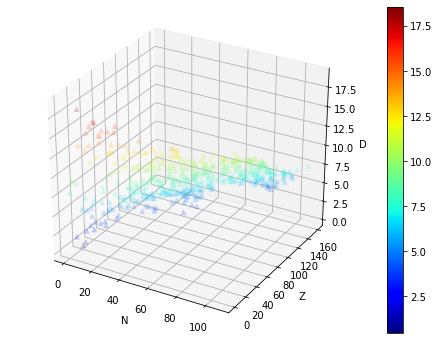

In [32]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [33]:
y_test_o.shape[0]


468

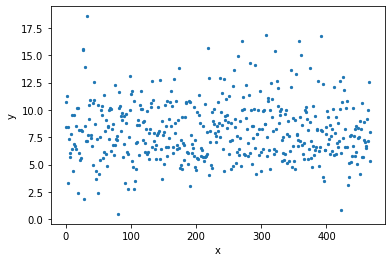

In [34]:
plt.scatter(range(y_new_inverse.shape[0]), y_new_inverse[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot _first 0th_ column of TEST set

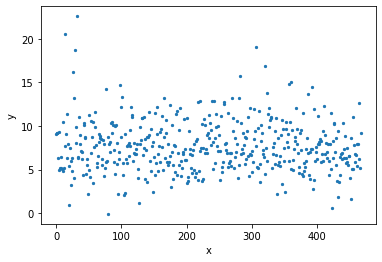

In [35]:
plt.scatter(range(y_test_o.shape[0]), y_test_o, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

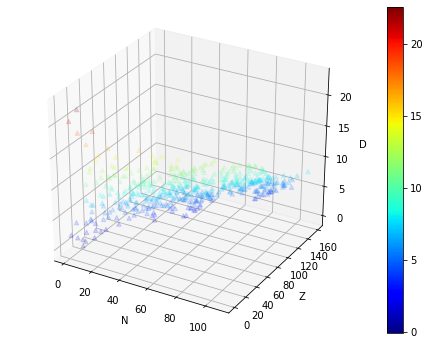

In [36]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = X_test_o[:,0]
ys = X_test_o[:,1]
zs = y_test_o[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Calculate _diff_ and _diff_abs_ (no distinction for columns)

In [37]:
#diff = np.square((y_new_inverse - y_test_o) / y_test_o)
substraction = y_new_inverse - y_test_o
diff = np.divide( substraction , y_test_o, out = substraction, where = y_test_o != 0)
diff_abs = y_new_inverse - y_test_o

In [38]:
print(diff.shape)
print(diff_abs.shape)

(468, 1)
(468, 1)


In [39]:
diff_df = pd.DataFrame(data={
                            'rel diff mass': diff[:,0],                            
                            'abs diff mass' : diff_abs[:,0]                             
                            })
diff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 2 columns):
rel diff mass    468 non-null float64
abs diff mass    468 non-null float64
dtypes: float64(2)
memory usage: 7.4 KB


# Replace inf and -inf with Nan, then drop the nans

In [40]:
diff_df = diff_df.replace([np.inf, -np.inf], np.nan)

In [41]:
print(diff_df.isnull().values.any())
print(diff_df.isnull().sum())
diff_df = diff_df.dropna()

False
rel diff mass    0
abs diff mass    0
dtype: int64


In [42]:
diff_df.describe()

,rel diff mass,abs diff mass
count,468.000000,468.000000
mean,0.092371,0.407721
std,0.478940,1.507364
min,-6.880173,-11.059822
25%,-0.076427,-0.629276
50%,0.082128,0.515732
75%,0.215331,1.384508
max,4.409763,7.340226


# Plot the relative diff of the first column

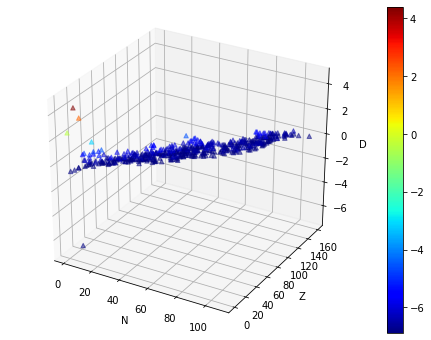

In [43]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = diff_df['rel diff mass']# diff[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.5)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [44]:
#%matplotlib notebook

In [45]:
vals = diff_df['rel diff mass'].to_numpy()
print(vals.shape)
print(vals.shape[0])

(468,)
468


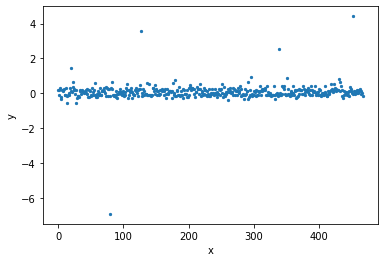

In [46]:
#plt.scatter(iterate_x, diff[:,0], s=5)

plt.scatter(range(vals.shape[0]),vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Diff ABSOLUTE of first column

In [47]:
vals = diff_df['abs diff mass'].to_numpy()
print(vals.shape)
range_x = range(vals.shape[0])

(468,)


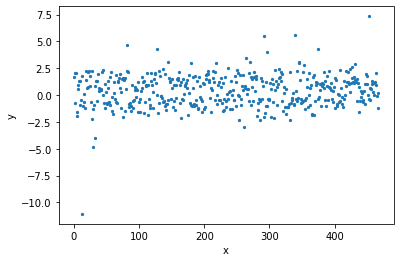

In [48]:
plt.scatter(range_x,vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()